In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin * (steps*self.resolution))
        
        # Create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
        
        # Create the Y data for the time series x axis from the previous step
        y_batch = np.sin(batch_ts)
        
        
        # FORMATTING FOR RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1) , y_batch[:,1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:, :-1].reshape(-1, steps, 1) , y_batch[:,1:].reshape(-1, steps, 1)

In [3]:
ts_data = TimeSeriesData(250, 0, 10)

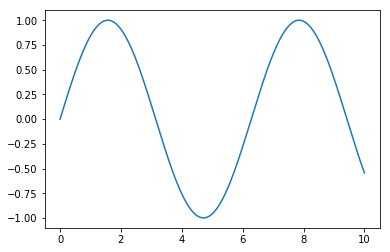

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

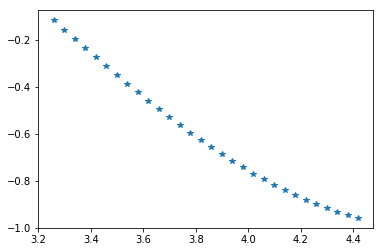

In [7]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

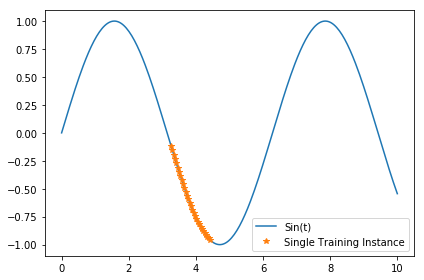

In [8]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label="Single Training Instance")

plt.legend()
plt.tight_layout()

In [9]:
# TRAINING DATA

In [10]:
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps + 1), num_time_steps+ 1) 

In [11]:
print(len(train_inst))
print(len(train_inst[:-1]))

31
30


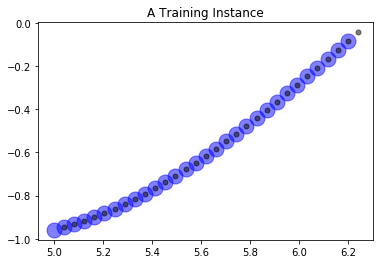

In [12]:
plt.title('A Training Instance')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='Instance')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]), 'ko', markersize=5, alpha=0.5, label='TARGET')

# Creating a Model

In [13]:
tf.reset_default_graph()

In [14]:
num_inputs = 1

In [15]:
num_neurons = 100

In [16]:
num_outputs = 1

In [17]:
learning_rate = 0.001

In [18]:
num_train_iterations = 2000

In [19]:
batch_size = 1

In [20]:
# PLACEHOLDERS

In [21]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])

In [22]:
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [23]:
# RNN CELL LAYER

In [24]:
cell = tf.contrib.rnn.GRUCell(num_units=num_neurons,activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)

In [25]:
output, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [26]:
# MSE
loss = tf.reduce_mean(tf.square(output - y))

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [28]:
train = optimizer.minimize(loss)

In [29]:
init = tf.global_variables_initializer()

In [30]:
# SESSION

In [31]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

In [32]:
saver = tf.train.Saver()

In [33]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
    
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y:y_batch})
            print(iteration, "\tMSE", mse)
    
    saver.save(sess, './RNN-sinusoid-predictor')

0 	MSE 0.105586
100 	MSE 0.0362563
200 	MSE 0.0165263
300 	MSE 0.0301263
400 	MSE 0.00150947
500 	MSE 0.00322434
600 	MSE 0.0045965
700 	MSE 0.00304363
800 	MSE 0.000959073
900 	MSE 0.000155868
1000 	MSE 0.000392462
1100 	MSE 0.00261329
1200 	MSE 0.00166546
1300 	MSE 0.000170465
1400 	MSE 8.14483e-05
1500 	MSE 0.000136824
1600 	MSE 0.000409045
1700 	MSE 3.10078e-05
1800 	MSE 8.06406e-05
1900 	MSE 4.49818e-05


In [34]:
with tf.Session() as sess:
    saver.restore(sess,'./RNN-sinusoid-predictor')
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(output, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./RNN-sinusoid-predictor


<function matplotlib.pyplot.tight_layout>

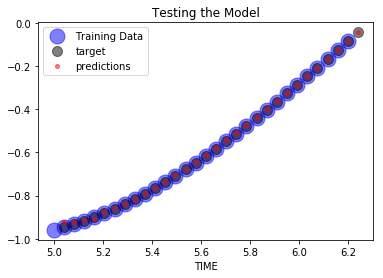

In [35]:
plt.title("Testing the Model")

# TRAINING INSTANCE
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='Training Data')

# TARGET TO PREDICT (CORRECT TEST VALUES NP.SIN(TRAIN))
plt.plot(train_inst[1:],np.sin(train_inst[1:]), 'ko', markersize=10, alpha=0.5, label='target')

# MODELS PREDICTION
plt.plot(train_inst[1:],y_pred[0,:,0], 'r.', markersize=8, alpha=0.5, label='predictions')

plt.xlabel('TIME')
plt.legend()
plt.tight_layout

# Generating Sequence

In [36]:
with tf.Session() as sess:
    
    saver.restore(sess,'./RNN-sinusoid-predictor')
    
    # SEED ZEROS
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        
        y_pred = sess.run(output, feed_dict={X:X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./RNN-sinusoid-predictor


Text(0,0.5,'Y')

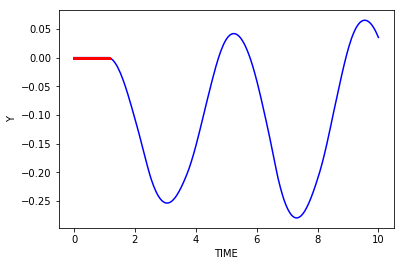

In [38]:
plt.plot(ts_data.x_data, zero_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps], 'r', linewidth=3)
plt.xlabel("TIME")
plt.ylabel("Y")

In [39]:
with tf.Session() as sess:
    
    saver.restore(sess,'./RNN-sinusoid-predictor')
    
    # SEED ZEROS
    training_data = list(ts_data.y_true[:30])
    
    for iteration in range(len(training_data)-num_time_steps):
        
        X_batch = np.array(training_data[-num_time_steps:]).reshape(1, num_time_steps, 1)
        
        y_pred = sess.run(output, feed_dict={X:X_batch})
        
        training_data.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./RNN-sinusoid-predictor


Text(0,0.5,'Y')

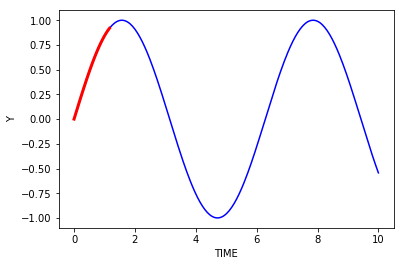

In [40]:
plt.plot(ts_data.x_data, ts_data.y_true, 'b-')
plt.plot(ts_data.x_data[:num_time_steps],training_data[:num_time_steps], 'r', linewidth=3)
plt.xlabel("TIME")
plt.ylabel("Y")